In [1]:
#if run on local server, the installation of pyreadr, numpy, matplotlib, pandas, geopandas, reverse_geocoder and bokeh is needed.
import pyreadr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import reverse_geocoder as rg #should use pip to install

import json
import math

import bokeh
from bokeh.io import show
from bokeh.models import (ColorBar, ColumnDataSource,
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider, Column,Legend,LegendItem)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.models import Range1d

from ipywidgets import interact, FloatSlider
from bokeh.io import output_notebook, show, push_notebook

output_notebook(hide_banner=True)

In [2]:
#import files : the dataset and the shapefile for the map
result = pyreadr.read_r('../Data/data_train_DF.RData') 
df1 = result["data_train_DF"]
df1['BA'] = df1['BA'].fillna(0)
df1['CNT'] = df1['CNT'].fillna(0)

#read shp file containing polygons of the US states 
#source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
states1=gpd.read_file("../Data/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

#extract example data
wf=df1[df1['year']==1993]
wf=wf[wf['month']==3]

In [3]:
#search where the coordinates are with reverse_geocoder, if not in the U.S. include in the closest U.S state
l=[]
for i in range(len(wf)):
    p=(wf.lat.iloc[i],wf.lon.iloc[i])
    l.append(p)
coor=l
res=rg.search(coor)#search where the location belongs to
for i in res:
    if i["admin1"]=='Tamaulipas':
        i["admin1"]='Texas'
    if i["admin1"]=='British Columbia':
        i["admin1"]='Washington'
    if i["admin1"]=='Ontario':
        i["admin1"]="Minnesota"
    if i["admin1"]=='Chihuahua':
        i["admin1"]="New Mexico"
    if i["admin1"]=='Coahuila':
        i["admin1"]="Texas"
    if i["admin1"]=='New Brunswick':
        i["admin1"]="Maine"
    if i["admin1"]=='Sonora':
        i["admin1"]='Arizona'
    if i["admin1"]=='Baja California':
        i["admin1"]='California'
    if i["admin1"]=='Quebec':
        i["admin1"]="New York"

Loading formatted geocoded file...


In [4]:
#useful dictionaries

#total area of the states
#source from https://www.census.gov/geographies/reference-files/2010/geo/state-area.html
totarea={
    "Alabama": 135767,
    "Arizona": 295234,
    "Arkansas": 137732,
    "California": 423967,
    "Colorado": 269601,
    "Connecticut": 14357,
    "Delaware": 6446,
    "Florida": 170312,
    "Georgia": 153910,
    "Idaho": 216443,
    "Illinois": 149995,
    "Indiana": 94326,
    "Iowa": 145746,
    "Kansas": 213100,
    "Kentucky": 104656,
    "Louisiana": 135659,
    "Maine": 91633,
    "Maryland": 32131,
    "Massachusetts": 27336,
    "Michigan": 250487,
    "Minnesota": 225163,
    "Mississippi": 125438,
    "Missouri": 180540,
    "Montana": 380831,
    "Nebraska": 200330,
    "Nevada": 286380,
    "New Hampshire": 24214,
    "New Jersey": 22591,
    "New Mexico": 314917,
    "New York": 141297,
    "North Carolina": 139391,
    "North Dakota": 183108,
    "Ohio": 116098,
    "Oklahoma": 181037,
    "Oregon": 254799,
    "Pennsylvania": 119280,
    "Rhode Island": 4001,
    "South Carolina": 82933,
    "South Dakota": 199729,
    "Tennessee": 109153,
    "Texas": 695662,
    "Utah": 219882,
    "Vermont": 24906,
    "Virginia": 110787,
    "Washington": 184661,
    "West Virginia": 62756,
    "Wisconsin": 169635,
    "Wyoming": 253335}

In [5]:
#initialize the counts for each state

def count_init():
    d={
    "Alabama": 0,
    "Alaska": 0,
    "Arizona": 0,
    "Arkansas": 0,
    "California": 0,
    "Colorado": 0,
    "Connecticut": 0,
    "District of Columbia": 0,
    "Delaware": 0,
    "Florida": 0,
    "Georgia": 0,
    "Hawaii": 0,
    "Idaho": 0,
    "Illinois": 0,
    "Indiana": 0,
    "Iowa": 0,
    "Kansas": 0,
    "Kentucky": 0,
    "Louisiana": 0,
    "Maine": 0,
    "Maryland": 0,
    "Massachusetts": 0,
    "Michigan": 0,
    "Minnesota": 0,
    "Mississippi": 0,
    "Missouri": 0,
    "Montana": 0,
    "Nebraska": 0,
    "Nevada": 0,
    "New Hampshire": 0,
    "New Jersey": 0,
    "New Mexico": 0,
    "New York": 0,
    "North Carolina": 0,
    "North Dakota": 0,
    "Ohio": 0,
    "Oklahoma": 0,
    "Oregon": 0,
    "Pennsylvania": 0,
    "Rhode Island": 0,
    "South Carolina": 0,
    "South Dakota": 0,
    "Tennessee": 0,
    "Texas": 0,
    "Utah": 0,
    "Vermont": 0,
    "Virginia": 0,
    "Washington": 0,
    "West Virginia": 0,
    "Wisconsin": 0,
    "Wyoming": 0}
    return d

#functions to update the dictionary

def countfire(res,df):#for CNT
    stcount=count_init()
    for i in range(len(res)):
        if res[i]['admin1'] in totarea.keys():
            stcount[res[i]['admin1']]+=df.CNT.iloc[i]/totarea[res[i]['admin1']]*100000
    return stcount

def areafire(res,df):#for BA
    stcount=count_init()
    for i in range(len(res)):
        if res[i]['admin1'] in totarea.keys():
            stcount[res[i]['admin1']]+=df.BA.iloc[i]/totarea[res[i]['admin1']]*10000
    return stcount

#Retrieve data from same month, and take the mean of the sum over the years

def countfirem(res,df,m):#for CNT per month
    l=[]
    stcount=count_init()
    for j in range(23):
        df1=df[df["year"]==1993+j]
        df1=df1[df1["month"]==m]
        l.append(countfire(res,df1))
    for d in l:
        for s in stcount.keys():
            stcount[s]+=d[s]/23
    return stcount


def areafirem(res,df,m):#for BA per month
    l=[]
    stcount=count_init()
    for j in range(23):
        df1=df[df["year"]==1993+j]
        df1=df1[df1["month"]==m]
        l.append(areafire(res,df1))
    for d in l:
        for s in stcount.keys():
            stcount[s]+=d[s]/23
    return stcount

#Retrieve data from same year, and take the mean of the sum over the months

def countfirey(res,df,y):#for CNT per year
    l=[]
    stcount=count_init()
    for j in range(7):
        df1=df[df["year"]==y]
        df1=df1[df1["month"]==3+j]
        l.append(countfire(res,df1))
    for d in l:
        for s in stcount.keys():
            stcount[s]+=d[s]/7
    return stcount

def areafirey(res,df,y):#for BA per year 
    l=[]
    stcount=count_init()
    for j in range(7):
        df1=df[df["year"]==y]
        df1=df1[df1["month"]==3+j]
        l.append(areafire(res,df1))
    for d in l:
        for s in stcount.keys():
            stcount[s]+=d[s]/7
    return stcount

In [6]:
#declare a class to avoid 'DataFrame' object has no attribute 'dtype' errors, and overwriting
class states: 
    def __init__(self):
        self.states=gpd.read_file("../Data/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")#have to recall for each update..?
        
    def add_column(self,colnum,colname,col):
        self.states.insert(colnum,colname,col,True)
        
    def delete_column(self,colname):
        self.states=self.states.drop(columns=[colname])

In [7]:
#inspired by: 
#- https://towardsdatascience.com/walkthrough-mapping-basics-with-bokeh-and-geopandas-in-python-43f40aa5b7e9
#- https://stackoverflow.com/questions/55362916/how-to-pass-the-slider-value-in-bokeh-back-to-python-code
#- https://stackoverflow.com/questions/56343933/bokeh-second-legend-showing-scatter-radius

#initialise s of object states
s=states()

#Sliders:
#    - month: month of the plot
#    - CNTBA: choice of the mode for color scale (CNT:0, BA:1)

def update(month,CNTBA):
    extract=df1[df1["month"]==month]
    
    if CNTBA==0:
        lcf=[]
        lcf1=[]
        cf=countfirem(res,extract,month)
        dcf=dict({'States':list(cf.keys()),'Number':list(cf.values())})
        for i in range(len(s.states)):
            if s.states["NAME"].iloc[i] in dcf["States"]:
                lcf1.append(cf[s.states["NAME"].iloc[i]])
                lcf.append(math.log(cf[s.states["NAME"].iloc[i]]+1))
            else:
                lcf1.append(0)
                lcf.append(0)
        s.add_column(2,"logcf",lcf)
        s.add_column(2,"cf",lcf1)
        geosource = GeoJSONDataSource(geojson = s.states.to_json())
        s.delete_column("logcf")
        s.delete_column("cf") 
        
    else:
        lba=[]
        lba1=[]
        ba=areafirem(res,extract,month)
        dba=dict({'States':list(ba.keys()),'Number':list(ba.values())})
        for i in range(len(s.states)):
            if s.states["NAME"].iloc[i] in dba["States"]:
                lba.append(math.log(ba[s.states["NAME"].iloc[i]]+1))
                lba1.append(ba[s.states["NAME"].iloc[i]])
            else:
                lba.append(0)
                lba1.append(0)
        s.add_column(2,"logba",lba)
        s.add_column(2,"ba",lba1)
        geosource = GeoJSONDataSource(geojson = s.states.to_json())
        s.delete_column("logba")
        s.delete_column("ba")

    palette = brewer['YlGnBu'][8]
    palette = palette[::-1] 

    color_mapper = LinearColorMapper(palette = palette, low = 0, high = 8)

    tick_labels = {"0": "2⁰", "1": "2¹",
     "2":"2²", "3":"2³",
     "4":"2⁴", "5":"2⁵",
     "6":"2⁶", "7":"2⁷",
     "8":"2⁸+"}

    color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = "horizontal",
                     major_label_overrides = tick_labels)

    if CNTBA==0:
        a="Number of wildfires"
        b="logcf"
    else:
        a="Burnt area from wildfires"
        b="logba"

    p = figure(title = 'Mean of '+a+' in the United States at month '+str(int(month)), 
           plot_height = 600 ,
           plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset,save")
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.x_range=Range1d(-127, -65)
    p.y_range=Range1d(23, 50)
    
    states1 = p.patches('xs','ys', source = geosource,
                   fill_color = {"field" :b,
                                 "transform" : color_mapper},
                   line_color = "gray", 
                   line_width = 0.25, 
                   fill_alpha = 1)
    
    if CNTBA==0:
        p.add_tools(HoverTool(renderers = [states1],
                      tooltips = [('State','@NAME'),
                                ('Number of Wildfires per 10⁵km²','@cf'),
                                ]))
    else:
        p.add_tools(HoverTool(renderers = [states1],
                      tooltips = [('State','@NAME'),
                                ('Burnt Area(acre) per 10⁴km²','@ba'),
                                ]))

    p.add_layout(color_bar, "below")
    output_notebook()
    show(p,notebook_handle=True)
    
    push_notebook()

_ = interact(update, month=FloatSlider(min=3, max=9, step=1, value= 3),
            CNTBA=FloatSlider(min=0,max=1,step=1,value=0))

interactive(children=(FloatSlider(value=3.0, description='month', max=9.0, min=3.0, step=1.0), FloatSlider(val…

In [8]:
#inspired by: 
#- https://towardsdatascience.com/walkthrough-mapping-basics-with-bokeh-and-geopandas-in-python-43f40aa5b7e9
#- https://stackoverflow.com/questions/55362916/how-to-pass-the-slider-value-in-bokeh-back-to-python-code
#- https://stackoverflow.com/questions/56343933/bokeh-second-legend-showing-scatter-radius

#initialise s of object states
s=states()

#Sliders:
#    - year: month of the plot
#    - CNTBA: choice of the mode for color scale (CNT:0, BA:1)

def update(year,CNTBA):
    extract=df1[df1["year"]==year]
    
    if CNTBA==0:
        lcf=[]
        lcf1=[]
        cf=countfirey(res,extract,year)
        dcf=dict({'States':list(cf.keys()),'Number':list(cf.values())})
        for i in range(len(s.states)):
            if s.states["NAME"].iloc[i] in dcf["States"]:
                lcf1.append(cf[s.states["NAME"].iloc[i]])
                lcf.append(math.log(cf[s.states["NAME"].iloc[i]]+1))
            else:
                lcf1.append(0)
                lcf.append(0)
        s.add_column(2,"logcf",lcf)
        s.add_column(2,"cf",lcf1)
        geosource = GeoJSONDataSource(geojson = s.states.to_json())
        s.delete_column("logcf")
        s.delete_column("cf") 
        
    else:
        lba=[]
        lba1=[]
        ba=areafirey(res,extract,year)
        dba=dict({'States':list(ba.keys()),'Number':list(ba.values())})
        for i in range(len(s.states)):
            if s.states["NAME"].iloc[i] in dba["States"]:
                lba.append(math.log(ba[s.states["NAME"].iloc[i]]+1))
                lba1.append(ba[s.states["NAME"].iloc[i]])
            else:
                lba.append(0)
                lba1.append(0)
        s.add_column(2,"logba",lba)
        s.add_column(2,"ba",lba1)
        geosource = GeoJSONDataSource(geojson = s.states.to_json())
        s.delete_column("logba")
        s.delete_column("ba")

    palette = brewer['YlGnBu'][8]
    palette = palette[::-1] 

    color_mapper = LinearColorMapper(palette = palette, low = 0, high = 8)

    tick_labels = {"0": "2⁰", "1": "2¹",
     "2":"2²", "3":"2³",
     "4":"2⁴", "5":"2⁵",
     "6":"2⁶", "7":"2⁷",
     "8":"2⁸+"}

    color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = "horizontal",
                     major_label_overrides = tick_labels)

    if CNTBA==0:
        a="Number of wildfires"
        b="logcf"
    else:
        a="Burnt area from wildfires"
        b="logba"

    p = figure(title = 'Mean of '+a+' in the United States at year '+str(int(year)), 
           plot_height = 600 ,
           plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset,save")
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.x_range=Range1d(-127, -65)
    p.y_range=Range1d(23, 50)
    
    states1 = p.patches('xs','ys', source = geosource,
                   fill_color = {"field" :b,
                                 "transform" : color_mapper},
                   line_color = "gray", 
                   line_width = 0.25, 
                   fill_alpha = 1)
    
    if CNTBA==0:
        p.add_tools(HoverTool(renderers = [states1],
                      tooltips = [('State','@NAME'),
                                ('Number of Wildfires per 10⁵km²','@cf'),
                                ]))
    else:
        p.add_tools(HoverTool(renderers = [states1],
                      tooltips = [('State','@NAME'),
                                ('Burnt Area(acre) per 10⁴km²','@ba'),
                                ]))

    p.add_layout(color_bar, "below")
    output_notebook()
    show(p,notebook_handle=True)
    
    push_notebook()

_ = interact(update, year =FloatSlider(min=1993, max=2015, step=1, value= 1993),
            CNTBA=FloatSlider(min=0,max=1,step=1,value=0))

interactive(children=(FloatSlider(value=1993.0, description='year', max=2015.0, min=1993.0, step=1.0), FloatSl…

In [9]:
#compute and plot the total burnt area and number of fire with respect to time
def totBA():
    l=[]
    for y in range(23):
        df3=df1[df1["year"]==y+1993]
        c=0
        for i in range(len(df3)):
            c+=df3["BA"].iloc[i]
        l.append(c)
    return l

In [10]:
l1=totBA()
dfba=pd.DataFrame({'y':l1})
l2=dfba.rolling(4).sum()
for i in range(3):
    l2["y"].iloc[i]=l1[i]
for i in range(3,23):
    l2["y"].iloc[i]=l2["y"].iloc[i]/4

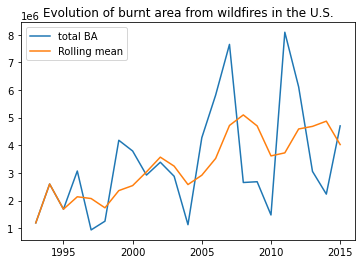

In [15]:
x=np.arange(1993,2016)
plt.title("Evolution of burnt area from wildfires in the U.S.")
plt.plot(x,l1,label="total BA")
plt.plot(x,l2,label="Rolling mean")
plt.legend()
plt.savefig("2.png")
plt.show()

In [12]:
def totCNT():
    l=[]
    for y in range(23):
        df3=df1[df1["year"]==y+1993]
        c=0
        for i in range(len(df3)):
            c+=df3["CNT"].iloc[i]
        l.append(c)
    return l

In [13]:
l3=totCNT()
dfcnt=pd.DataFrame({'y':l3})
l4=dfcnt.rolling(4).sum()
for i in range(3):
    l4["y"].iloc[i]=l3[i]
for i in range(3,23):
    l4["y"].iloc[i]=l4["y"].iloc[i]/4

,y
0,45459.00
1,41637.00
2,53062.00
3,45072.75
4,45649.75
5,44111.00
6,46362.75
7,47739.75
8,49258.50
9,50229.50


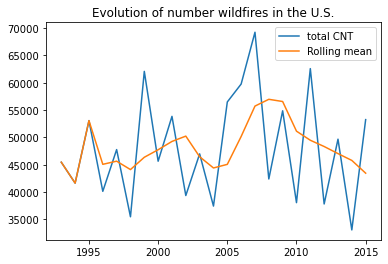

In [17]:
x=np.arange(1993,2016)
plt.title("Evolution of number wildfires in the U.S.",)
plt.plot(x,l3,label="total CNT")
plt.plot(x,l4,label="Rolling mean")
plt.legend()
plt.savefig("3.png")
plt.show()